In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

In [2]:
# Path to your event files
event_files = glob.glob("../../runs/sac/sac_0.0_False_2.0_0.05_4000000_1769853898/events.*", recursive=True)

all_data = []

for file in event_files:
    for e in tf.compat.v1.train.summary_iterator(file):
        for v in e.summary.value:
            if v.HasField('simple_value'):  # Scalars only
                all_data.append({
                    'file': os.path.basename(file),
                    "path": file,
                    'tag': v.tag,
                    'step': e.step,
                    'value': v.simple_value
                })

df = pd.DataFrame(all_data)
print(df.head())


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
                                                file  \
0  events.out.tfevents.1769853898.tcml-node38.138...   
1  events.out.tfevents.1769853898.tcml-node38.138...   
2  events.out.tfevents.1769853898.tcml-node38.138...   
3  events.out.tfevents.1769853898.tcml-node38.138...   
4  events.out.tfevents.1769853898.tcml-node38.138...   

                                                path                     tag  \
0  ../../runs/sac/sac_0.0_False_2.0_0.05_4000000_...  charts/episodic_return   
1  ../../runs/sac/sac_0.0_False_2.0_0.05_4000000_...  charts/episodic_length   
2  ../../runs/sac/sac_0.0_False_2.0_0.05_4000000_...  charts/episodic_return   
3  ../../runs/sac/sac_0.0_False_2.0_0.05_4000000_...  charts/episodic_length   
4  ../../runs/sac/sac_0.0_False_2.0_0.05_4000000_...  charts/episodic_return   

   step      value  
0    30 -10.744033  
1    30  31.000000  
2    37 -10.708597  
3    37  38.

In [3]:
tag_to_plot = "charts/episodic_return"
df_filtered = df[df['tag'] == tag_to_plot]
df_filtered = df_filtered[["path", "step", "value"]]
df_filtered["path"] = df_filtered["path"].str.slice(28, 60)
print(df_filtered.head())

                               path  step      value
0  _2.0_0.05_4000000_1769853898\eve    30 -10.744033
2  _2.0_0.05_4000000_1769853898\eve    37 -10.708597
4  _2.0_0.05_4000000_1769853898\eve    79 -11.403031
6  _2.0_0.05_4000000_1769853898\eve   122   5.667520
8  _2.0_0.05_4000000_1769853898\eve   250  -0.494505


In [4]:
df_filtered["value_smooth"] = (
    df_filtered.groupby("path")["value"]
      .rolling(window=int(1e3), min_periods=int(1))
      .mean()
      .reset_index(level=0, drop=True)
)

In [5]:
df_filtered["group key"] = df_filtered["path"]
df_filtered_2 = df_filtered[df_filtered["step"]<=2e6]

C:\Users\below\AppData\Local\Temp\ipykernel_19192\2182632879.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


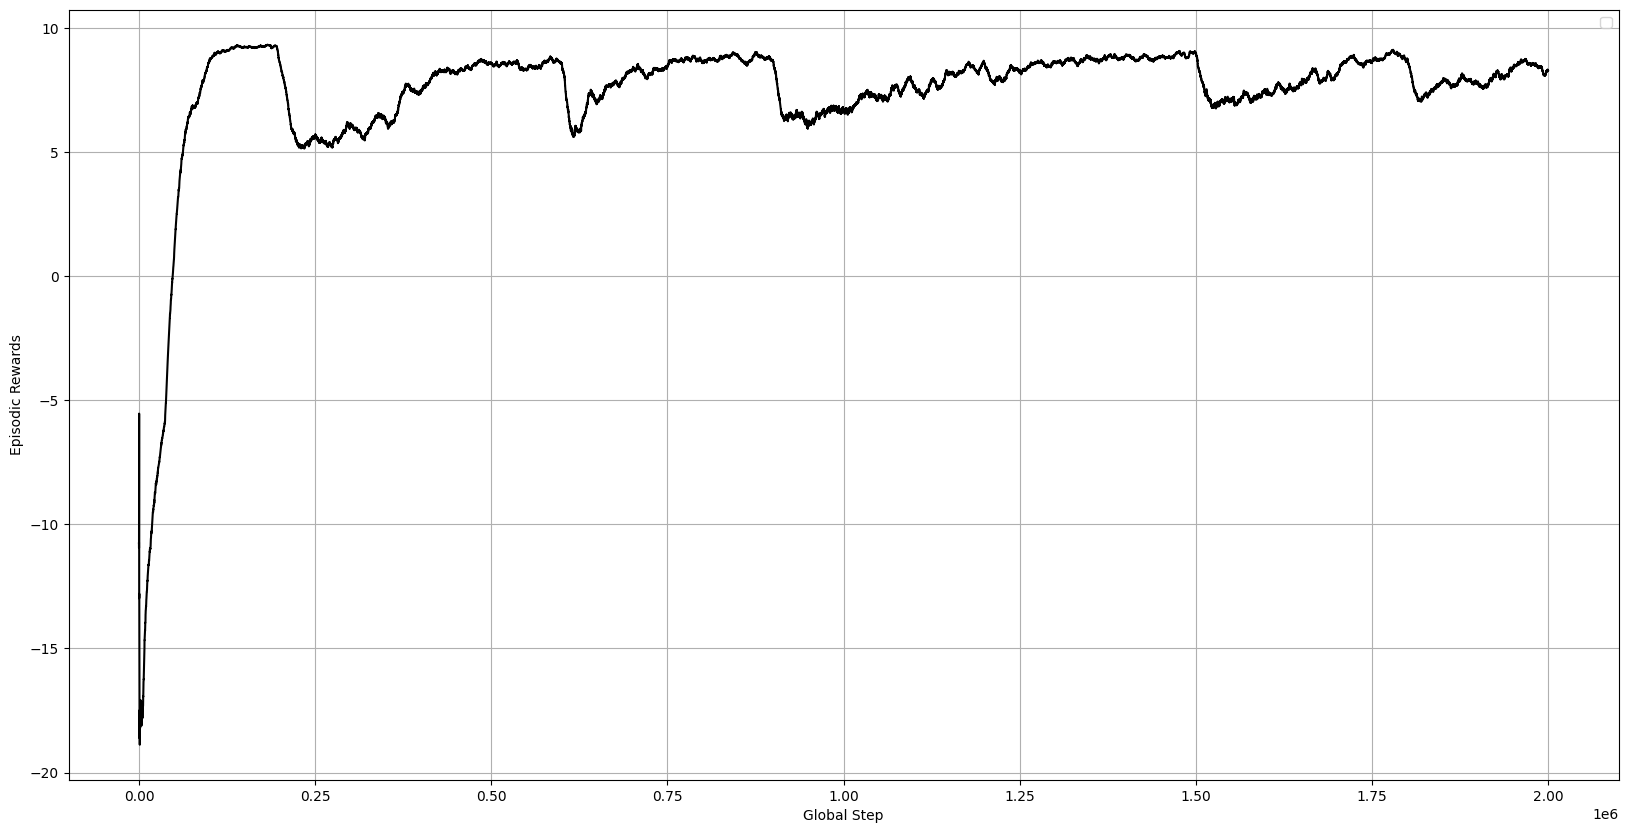

In [6]:
fig, ax = plt.subplots()
colors = ["black", "gray", "rosybrown", "lightcoral", "firebrick", "red", "peru", "darkorange", "goldenrod", "palegoldenrod", "yellow", "olive", "greenyellow", "darkseagreen", "turquoise", "teal", "indigo"]
for index, g in enumerate(df_filtered_2.groupby("group key")):
    ax.plot(g[1]["step"], g[1]["value_smooth"], label=g[0], color=colors[index])
ax.grid()
fig.set_size_inches(20, 10)
plt.xlabel("Global Step")
plt.ylabel("Episodic Rewards")
plt.legend()
plt.show()

In [7]:
fig.savefig('experiments.pdf')